# Load assessment data CSV

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
plt.style.use('seaborn-whitegrid')

# Some easy colors of graphs
color1='#a6cee3'
color2='#1f78b4'
color3='#b2df8a'
color4='#33a02c'
color5='#fb9a99'
color6='#e31a1c'

pd.set_option('display.max_rows', 10)
pd.set_option('precision', 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Fetch the CSV
url = 'https://raw.githubusercontent.com/nbdata/assessment-parser/master/output.csv'
df = pd.read_csv(url)
df.sort_values(by='ID')

# Build some dynamic values
df['PricePerSqFt'] = df['2020 Full'] / df['SqFt']
df['AV Diff'] = 100 * ((df['Sale Price'] - df['Sale AV']) / df['Sale AV'])
df['SaleDateTime'] = pd.to_datetime(df['Sale Date'], format="%m/%d/%Y", errors='coerce')
df['RecentSale'] = df['SaleDateTime'].notnull().astype('bool')
df['SaleYear'] = df['SaleDateTime'].dt.year.astype('Int64')
df['2017NoChange'] = df['2016 Full'] == df['2017 Full']
df['2018NoChange'] = df['2017 Full'] == df['2018 Full']
df['2019NoChange'] = df['2018 Full'] == df['2019 Full']
df['2020NoChange'] = df['2019 Full'] == df['2020 Full']

# Modify some column types
df['2020Vacant'] = df['2020Vacant'].astype('bool')
df['2020Violations'] = df['2020Violations'].astype('bool')
df['OpportunityZone'] = df['OpportunityZone'].astype('bool')
df['NbhdCode'] = df['NbhdCode'].fillna(0).astype('int64')
df['TaxMap'] = df.ID.apply(lambda x: x.split('-')[0])
df['TaxMap'] = df.TaxMap.apply(lambda x: x.split('.')[0])
df['TaxMap'] = df.TaxMap.astype('int64')

# Setup homestead vs non-homestead
homestead = df[df['Non-Homestead'] == 0]
nonHomestead = df[df['Non-Homestead'] == 1]

# Now can calculate tax
df['2020Tax'] = (19.606286 + (df['Non-Homestead'] * (27.933692-19.606286))) * df['2019 City'] / 1000

# Setup exempt and non-exempt
exempt = df[df['2020 City'] < 1]
ne = df[df['2019 City'] > 1]

# Single family and multi-family (only care about non-exempt)
sf = ne[ne['Code'] == 210].reset_index()
mf = ne[ne.Code.isin([220, 230, 411])]
sfAndMF = ne[ne.Code.isin([210, 220, 230, 411])]

# Only places that were sold
sold = df[df['Sale Price'] > 0].reset_index()
soldSF = sf[sf['Sale Price'] > 0].reset_index()
soldMF = mf[mf['Sale Price'] > 0].reset_index()

df.tail(20)

,ID,Street,Non-Homestead,Account,Code,2016 City,2016 Full,2017 City,2017 Full,2018 City,2018 Full,2019 City,2019 Full,2020 City,2020 Full,2021 City,2021 Full,Sale Date,Sale Price,Sale AV,2016OwnerAtAddress,2017OwnerAtAddress,2018OwnerAtAddress,2019OwnerAtAddress,2020OwnerAtAddress,Latitude,Longitude,TigerLine,20162020Diff,SaleAssessDiff,SqFt,Bathrooms,Bedrooms,YearBuilt,LandSize,Zoning,Ward,CensusBlock,AVPerSqFt,AVChangePercent,SalePricePerSqFt,NbhdCode,2020Vacant,2020Violations,OpportunityZone,PricePerSqFt,AV Diff,SaleDateTime,RecentSale,SaleYear,2017NoChange,2018NoChange,2019NoChange,2020NoChange,TaxMap,2020Tax
6904,9-5-1.11,367 Water St,1,676890,963,0.00,2000.00,0.00,1900.00,0.00,1900.00,0.00,2400.00,0,2400,0,2400,NaN,nan,nan,2,2,2,2,2,nan,nan,nan,400.00,nan,nan,nan,nan,nan,0.07,Residential Low Density,Ward 1,County 071 Tract 000400 Block Group 1,inf,0.20,nan,22,False,False,True,nan,nan,NaT,False,<NA>,False,True,False,True,9,0.00
6905,9-5-30,260 Montgomery St,0,217325,210,293100.00,313100.00,269500.00,289500.00,269500.00,289500.00,269500.00,289500.00,313300,333300,313300,333300,NaN,nan,nan,1,1,1,1,1,41.51,-74.01,124414122.00,20200.00,nan,1992.00,3.50,2.00,2003.00,0.11,Residential Low Density,Ward 1,County 071 Tract 000400 Block Group 1,167.32,0.06,nan,7,False,False,True,167.32,nan,NaT,False,<NA>,False,True,True,False,9,5283.89
6906,9-5-31,262 Montgomery St,0,217326,210,280000.00,280000.00,281900.00,281900.00,281900.00,281900.00,281900.00,281900.00,321100,321100,321100,321100,8/21/2014,278000.00,292000.00,1,1,1,1,1,41.51,-74.01,124414122.00,41100.00,-14000.00,1954.00,2.50,3.00,2004.00,0.11,Residential Low Density,Ward 1,County 071 Tract 000400 Block Group 1,164.33,0.15,142.27,7,False,False,True,164.33,-4.79,2014-08-21,True,2014,False,True,True,False,9,5527.01
6907,9-5-32,264 Montgomery St,0,217327,210,283000.00,283000.00,292900.00,292900.00,292900.00,292900.00,292900.00,292900.00,364400,364400,364400,364400,7/10/2018,337500.00,292900.00,1,1,1,1,1,41.51,-74.01,124414122.00,81400.00,44600.00,4192.00,5.00,5.00,2004.00,0.17,Residential Low Density,Ward 1,County 071 Tract 000400 Block Group 1,86.93,0.29,80.51,7,False,False,True,86.93,15.23,2018-07-10,True,2018,False,True,True,False,9,5742.68
6908,9-5-33,266 Montgomery St,0,217328,210,304900.00,304900.00,286300.00,286300.00,286300.00,286300.00,286300.00,286300.00,325400,325400,325400,325400,6/13/2018,300000.00,286300.00,0,0,0,1,1,41.51,-74.01,124414122.00,20500.00,13700.00,1954.00,2.50,3.00,2004.00,0.16,Residential Low Density,Ward 1,County 071 Tract 000400 Block Group 1,166.53,0.07,153.53,7,False,False,True,166.53,4.79,2018-06-13,True,2018,False,True,True,False,9,5613.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6919,999-1-181,New Rd,1,566900,866,5843354.00,5843354.00,5186092.00,5186092.00,4706835.00,4706835.00,4531963.00,4531963.00,4509656,4509700,4509656,4509656,NaN,nan,nan,0,0,0,0,0,nan,nan,nan,-1333654.00,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,nan,-0.23,nan,0,False,False,False,nan,nan,NaT,False,<NA>,False,False,False,False,999,126594.46
6920,999-1-182,NaN,1,566950,869,540922.00,540922.00,626290.00,626290.00,675808.00,675808.00,661745.00,661745.00,611896,611900,611896,611896,NaN,nan,nan,0,0,0,0,0,nan,nan,nan,70978.00,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,nan,0.13,nan,0,False,False,False,nan,nan,NaT,False,<NA>,False,False,False,False,999,18484.98
6921,999-1-183,NaN,1,566800,866,61846.00,61846.00,59200.00,59200.00,56286.00,56286.00,50681.00,50681.00,56965,57000,56965,56965,NaN,nan,nan,0,0,0,0,0,nan,nan,nan,-4846.00,nan,nan,nan,nan,nan,nan,NaN,NaN,NaN,nan,-0.08,nan,0,False,False,False,nan,nan,NaT,False,<NA>,False,False,False,False,999,1415.71
6922,999-1-184,NaN,1,567000,869,5272.00,5272.00,5016.00,5016.00,4612.00,4612.00,4204.00,4204.00,3745,3700,3745,3745,NaN,nan,nan,3,3,3,3,3,nan,nan,nan,-1572.00,nan

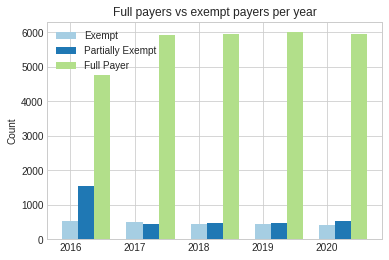

In [ ]:
ex1 = np.array([
    df[(df['2016 City'] < 1) & (df['2016 Full'] > 1)].count()[0],
    df[(df['2017 City'] < 1) & (df['2017 Full'] > 1)].count()[0],
    df[(df['2018 City'] < 1) & (df['2018 Full'] > 1)].count()[0],
    df[(df['2019 City'] < 1) & (df['2019 Full'] > 1)].count()[0],
    df[(df['2020 City'] < 1) & (df['2020 Full'] > 1)].count()[0]
])

ex2 = np.array([
    df[(df['2016 City'] < df['2016 Full'])].count()[0] - ex1[0],
    df[(df['2017 City'] < df['2017 Full'])].count()[0] - ex1[1],
    df[(df['2018 City'] < df['2018 Full'])].count()[0] - ex1[2],
    df[(df['2019 City'] < df['2019 Full'])].count()[0] - ex1[3],
    df[(df['2020 City'] < df['2020 Full'])].count()[0] - ex1[4]
])

fullPayer = np.array([
    df[(df['2016 City'] == df['2016 Full'])].count()[0],
    df[(df['2017 City'] == df['2017 Full'])].count()[0],
    df[(df['2018 City'] == df['2018 Full'])].count()[0],
    df[(df['2019 City'] == df['2019 Full'])].count()[0],
    df[(df['2020 City'] == df['2020 Full'])].count()[0]
])

barWidth=0.25
r1 = np.array([2016,2017,2018,2019,2020])
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]


plt.bar(r1, ex1, color=color1, width=0.25, label='Exempt')
plt.bar(r2, ex2, color=color2, width=0.25, label='Partially Exempt')
plt.bar(r3, fullPayer, color=color3, width=0.25, label='Full Payer')
plt.ylabel('Count')
plt.title('Full payers vs exempt payers per year')
plt.legend()
plt.show()

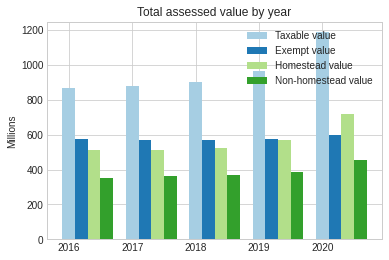

In [ ]:
totalCityAssessment = np.array([
    df['2016 City'].sum()/1000/1000,
    df['2017 City'].sum()/1000/1000,
    df['2018 City'].sum()/1000/1000,
    df['2019 City'].sum()/1000/1000,
    df['2020 City'].sum()/1000/1000
])

totalHomesteadAssessment = np.array([
    homestead['2016 City'].sum()/1000/1000,
    homestead['2017 City'].sum()/1000/1000,
    homestead['2018 City'].sum()/1000/1000,
    homestead['2019 City'].sum()/1000/1000,
    homestead['2020 City'].sum()/1000/1000
])

totalNonHomesteadAssessment = np.array([
    nonHomestead['2016 City'].sum()/1000/1000,
    nonHomestead['2017 City'].sum()/1000/1000,
    nonHomestead['2018 City'].sum()/1000/1000,
    nonHomestead['2019 City'].sum()/1000/1000,
    nonHomestead['2020 City'].sum()/1000/1000
])

totalExemptCityAssessment = np.array([
    (df['2016 Full'].sum() - df['2016 City'].sum()) /1000/1000,
    (df['2017 Full'].sum() - df['2017 City'].sum()) /1000/1000,
    (df['2018 Full'].sum() - df['2018 City'].sum()) /1000/1000,
    (df['2019 Full'].sum() - df['2019 City'].sum()) /1000/1000,
    (df['2020 Full'].sum() - df['2020 City'].sum()) /1000/1000,
])


barWidth=0.2
r1 = np.array([2016,2017,2018,2019,2020])
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]


plt.bar(r1, totalCityAssessment, color=color1, width=barWidth, label='Taxable value')
plt.bar(r2, totalExemptCityAssessment, color=color2, width=barWidth, label='Exempt value')
plt.bar(r3, totalHomesteadAssessment, color=color3, width=barWidth, label='Homestead value')
plt.bar(r4, totalNonHomesteadAssessment, color=color4, width=barWidth, label='Non-homestead value')
plt.ylabel('Millions')
plt.title('Total assessed value by year')
plt.legend()
plt.show()

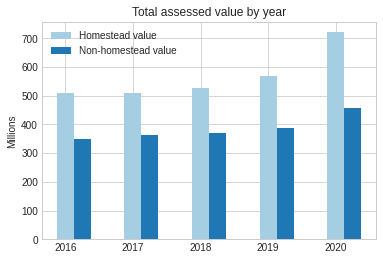

In [ ]:
totalCityAssessment = np.array([
    df['2016 City'].sum()/1000/1000,
    df['2017 City'].sum()/1000/1000,
    df['2018 City'].sum()/1000/1000,
    df['2019 City'].sum()/1000/1000,
    df['2020 City'].sum()/1000/1000
])

totalHomesteadAssessment = np.array([
    homestead['2016 City'].sum()/1000/1000,
    homestead['2017 City'].sum()/1000/1000,
    homestead['2018 City'].sum()/1000/1000,
    homestead['2019 City'].sum()/1000/1000,
    homestead['2020 City'].sum()/1000/1000
])

totalNonHomesteadAssessment = np.array([
    nonHomestead['2016 City'].sum()/1000/1000,
    nonHomestead['2017 City'].sum()/1000/1000,
    nonHomestead['2018 City'].sum()/1000/1000,
    nonHomestead['2019 City'].sum()/1000/1000,
    nonHomestead['2020 City'].sum()/1000/1000
])

totalExemptCityAssessment = np.array([
    (df['2016 Full'].sum() - df['2016 City'].sum()) /1000/1000,
    (df['2017 Full'].sum() - df['2017 City'].sum()) /1000/1000,
    (df['2018 Full'].sum() - df['2018 City'].sum()) /1000/1000,
    (df['2019 Full'].sum() - df['2019 City'].sum()) /1000/1000,
    (df['2020 Full'].sum() - df['2020 City'].sum()) /1000/1000,
])


barWidth=0.25
r1 = np.array([2016,2017,2018,2019,2020])
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]


plt.bar(r1, totalHomesteadAssessment, color=color1, width=0.25, label='Homestead value')
plt.bar(r2, totalNonHomesteadAssessment, color=color2, width=0.25, label='Non-homestead value')
plt.ylabel('Millions')
plt.title('Total assessed value by year')
plt.legend()
plt.show()

# Non-exempt properties 2019, 2020

# Count of exempt properties by class code



```
620 = Religious
963 = City Public Park
438 = Parking Lot
330 = Vacant Commercial
210 = Single-family
311 = Vacant Residential
```



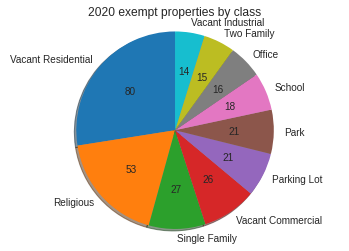

In [ ]:
ex_agg = exempt[['Code', '2020 Full']].groupby('Code', as_index=False)['2020 Full'].agg({'avg':'mean', 'count':'count'})
ex_cnt = ex_agg[ex_agg['count'] > 10].sort_values(by=['count'], ascending=False).head(10)
#print(ex_cnt.to_string(index=False))
ex_cnt

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return val
        #return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

labels = ex_cnt['Code'].replace(
    [311, 620, 963, 438, 210, 330, 612, 464, 220, 340], 
    ['Vacant Residential', 'Religious', 'Park', 'Parking Lot', 'Single Family', 'Vacant Commercial', 'School', 'Office', 'Two Family', 'Vacant Industrial'])

fig1, ax1 = plt.subplots()
ax1.pie(ex_cnt['count'], labels=labels, autopct=make_autopct(ex_cnt['count']),
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('2020 exempt properties by class')
plt.show()



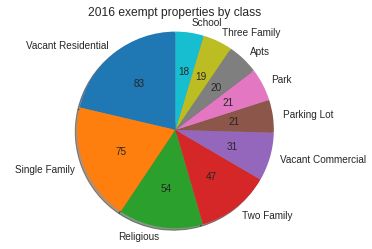

In [ ]:
exempt2016 = df[df['2016 City'] < 1]
ex_agg = exempt2016[['Code', '2016 Full']].groupby('Code', as_index=False)['2016 Full'].agg({'avg':'mean', 'count':'count'})
ex_cnt = ex_agg[ex_agg['count'] > 10].sort_values(by=['count'], ascending=False).head(10)
#print(ex_cnt.to_string(index=False))
ex_cnt

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return val
        #return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

labels = ex_cnt['Code'].replace(
    [311, 620, 963, 438, 210, 330, 612, 464, 220, 340, 411, 230], 
    ['Vacant Residential', 'Religious', 'Park', 'Parking Lot', 'Single Family', 'Vacant Commercial', 'School', 'Office', 'Two Family', 'Vacant Industrial', 'Apts', 'Three Family'])

fig1, ax1 = plt.subplots()
ax1.pie(ex_cnt['count'], labels=labels, autopct=make_autopct(ex_cnt['count']),
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('2016 exempt properties by class')
plt.show()

# Does owner address match property address?

0 = Out-of-state
1 = Yes
2 = Elsewhere in Newburgh
3 = Elsewhere in NY

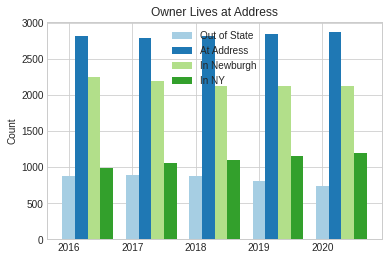

In [ ]:
oaa0 = np.array([
    df[(df['2016OwnerAtAddress'] == 0)].count()[0],
    df[(df['2017OwnerAtAddress'] == 0)].count()[0],
    df[(df['2018OwnerAtAddress'] == 0)].count()[0],
    df[(df['2019OwnerAtAddress'] == 0)].count()[0],
    df[(df['2020OwnerAtAddress'] == 0)].count()[0]
])

oaa1 = np.array([
    df[(df['2016OwnerAtAddress'] == 1)].count()[0],
    df[(df['2017OwnerAtAddress'] == 1)].count()[0],
    df[(df['2018OwnerAtAddress'] == 1)].count()[0],
    df[(df['2019OwnerAtAddress'] == 1)].count()[0],
    df[(df['2020OwnerAtAddress'] == 1)].count()[0]
])

oaa2 = np.array([
    df[(df['2016OwnerAtAddress'] == 2)].count()[0],
    df[(df['2017OwnerAtAddress'] == 2)].count()[0],
    df[(df['2018OwnerAtAddress'] == 2)].count()[0],
    df[(df['2019OwnerAtAddress'] == 2)].count()[0],
    df[(df['2020OwnerAtAddress'] == 2)].count()[0]
])

oaa3 = np.array([
    df[(df['2016OwnerAtAddress'] == 3)].count()[0],
    df[(df['2017OwnerAtAddress'] == 3)].count()[0],
    df[(df['2018OwnerAtAddress'] == 3)].count()[0],
    df[(df['2019OwnerAtAddress'] == 3)].count()[0],
    df[(df['2020OwnerAtAddress'] == 3)].count()[0]
])


barWidth=0.2
r1 = np.array([2016,2017,2018,2019,2020])
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.bar(r1, oaa0, color=color1, width=0.2, label='Out of State')
plt.bar(r2, oaa1, color=color2, width=0.2, label='At Address')
plt.bar(r3, oaa2, color=color3, width=0.2, label='In Newburgh')
plt.bar(r4, oaa3, color=color4, width=0.2, label='In NY')
plt.ylabel('Count')
plt.title('Owner Lives at Address')
plt.legend()
plt.show()

# What percentage of 2020 full market value is exempt?

In [ ]:
totalsum = df['2020 Full'].sum()
exemptsum = exempt['2020 Full'].sum()
exemptsum / totalsum

0.31451180135268014

# What were the biggest increases in single-family assessed value 2016 - 2017?

In [ ]:

sf['2017 Dollar Increase'] = sf['2017 Full'] - sf['2016 Full']
sf['2017 Increase'] = 100 * (sf['2017 Dollar Increase'] / sf['2016 Full'])
sf[['ID', 'Street', '2016 Full', '2017 Full', '2017 Increase']].sort_values(by=['2017 Increase'], ascending=False).head(10)


,ID,Street,2016 Full,2017 Full,2017 Increase
1482,26-3-5.3,23 Morris Ave,22500.00,189720.00,743.20
1902,36-2-15,152 Ann St,1500.00,12000.00,700.00
2125,4-8-20,21 Leroy Pl,45000.00,339200.00,653.78
2290,48-12-22,84 Henry Ave,19800.00,134400.00,578.79
1901,36-2-13.2,150 Ann St,1800.00,12000.00,566.67
1903,36-2-16,154 Ann St,2000.00,12000.00,500.00
1410,26-1-6.1,157 Dupont Ave Front,21600.00,67400.00,212.04
1174,22-5-30,254 First St,15500.00,45900.00,196.13
71,11-5-10,309 Liberty St,10300.00,30100.00,192.23
2313,48-3-22,24 Courtney Ave,74600.00,174200.00,133.51


# What were the biggest increases in single-family assessed value 2017 - 2018?

In [ ]:
sf['2018 Dollar Increase'] = sf['2018 Full'] - sf['2017 Full']
sf['2018 Increase'] = 100 * (sf['2018 Dollar Increase'] / sf['2017 Full'])
sf[['ID', 'Street', '2017 Full', '2018 Full', '2018 Increase']].sort_values(by=['2018 Increase'], ascending=False).head(10)

,ID,Street,2017 Full,2018 Full,2018 Increase
1904,36-2-17,156 Ann St,12000.00,145200.00,1110.00
1901,36-2-13.2,150 Ann St,12000.00,145200.00,1110.00
1902,36-2-15,152 Ann St,12000.00,145200.00,1110.00
1903,36-2-16,154 Ann St,12000.00,145200.00,1110.00
238,14-2-16.13,156 Orchard St,24600.00,208500.00,747.56
237,14-2-16.12,144 Orchard St,24500.00,195200.00,696.73
742,18-4-45,155 Lander St,12900.00,74400.00,476.74
2202,45-6-19,44 Carson Ave,43700.00,250000.00,472.08
1045,20-3-34,446 First St,26600.00,116700.00,338.72
1054,21-1-1,387 Third St,33900.00,140600.00,314.75


# What were the biggest increases in single-family assessed value 2018 - 2020?

In [ ]:
sf['2020 Dollar Increase'] = sf['2020 Full'] - sf['2018 Full']
sf['2020 Increase'] = 100 * (sf['2020 Dollar Increase'] / sf['2018 Full'])
sf[['ID', 'Street', '2018 Full', '2020 Full', '2020 Increase']].sort_values(by=['2020 Increase'], ascending=False).head(10)

,ID,Street,2018 Full,2020 Full,2020 Increase
1816,30-2-19,21 Johnston St,10900.00,175400,1509.17
1815,30-2-18,23 Johnston St,10900.00,175400,1509.17
2314,48-3-24,28 Courtney Ave,19300.00,167300,766.84
1791,3-9-27,324 Robinson Ave,20500.00,172800,742.93
1953,38-2-42,120 W Parmenter St,26900.00,189300,603.72
2746,7-1-14,15 Sequestered Rd,32900.00,211700,543.47
1819,30-2-37,20 S Miller St,26700.00,163100,510.86
2008,39-2-19,89 William St,28000.00,159400,469.29
1630,29-1-10,49 Concord St,19800.00,103600,423.23
1113,21-5-6,2 Lincoln Ter,43800.00,216000,393.15


# How many taxable properties had no assessment change 2017-2020?

In [ ]:
# Where 2016 and 2020 are identical
nochange = df[df['2020 Full'] == df['2017 Full']]
# Remove exempt and properties worth less than 20k
nochange = nochange[nochange['2020 City'] > 20000]
# Aggregate by ward
nochange[['ID', 'Ward']].groupby(['Ward']).agg('count')

,ID
Ward,
Ward 1,13
Ward 2,12
Ward 3,44
Ward 4,12


# What were the biggest decreases in single-family assessed value 2018 - 2020?

In [ ]:
sf[['ID', 'Street', '2018 Full', '2020 Full', '2020 Increase']].sort_values(by=['2020 Increase'], ascending=True).head(10)

,ID,Street,2018 Full,2020 Full,2020 Increase
3,10-1-20,82 Clinton St,144800.00,66300,-54.21
2177,45-10-18,130 Carson Ave,32100.00,15900,-50.47
2073,4-10-30,520 Liberty St,110000.00,63100,-42.64
2182,45-10-23,140 Carson Ave,37400.00,21600,-42.25
2179,45-10-20,134 Carson Ave,31700.00,18600,-41.32
1781,3-9-1,7 Cottage Ave,124500.00,78300,-37.11
2175,45-10-16,126 Carson Ave,34700.00,22200,-36.02
2920,7-7-41,260 Carpenter Ave,168600.00,113500,-32.68
1026,20-2-8,409 Third St,119700.00,81000,-32.33
767,18-9-7,117 Chambers St,96200.00,65100,-32.33


# What is the breakdown between homestead and non-homestead?

```
0 = Homestead
1 = Non-Homestead
2 = Non-HMSTD (Special)
```



In [ ]:
df[['ID', 'Non-Homestead', '2020 Full']].groupby('Non-Homestead').describe()

2020 Full                       ...                                
                  count      mean        std  ...       50%       75%         max
Non-Homestead                                 ...                                
0               5265.00 143491.13   77081.89  ... 142100.00 183000.00   626000.00
1               1620.00 631433.83 3268728.44  ... 197400.00 364800.00 71634800.00
2                 39.00 255689.74  154039.36  ... 229400.00 267950.00   981500.00

[3 rows x 8 columns]

# 2020 Full Market value breakdown by class code

Description of [class codes is available here](https://www.cityofnewburgh-ny.gov/sites/newburghny/files/u153/property_class_codes.pdf) 

In [ ]:
df[['ID', 'Code', '2020 Full']].groupby(['Code']).describe()

2020 Full                       ...                                 
         count       mean       std  ...        50%        75%        max
Code                                 ...                                 
210    3064.00  154107.08  68176.77  ...  145600.00  186600.00  528500.00
220    1243.00  149166.21  60825.85  ...  143100.00  175550.00  626000.00
230     456.00  187414.69  71343.10  ...  180450.00  216750.00  520000.00
271       1.00   66900.00       nan  ...   66900.00   66900.00   66900.00
280      18.00  256000.00 125482.71  ...  225500.00  275725.00  620900.00
...        ...        ...       ...  ...        ...        ...        ...
882       1.00     700.00       nan  ...     700.00     700.00     700.00
884       1.00 2566100.00       nan  ... 2566100.00 2566100.00 2566100.00
885       1.00  653600.00       nan  ...  653600.00  653600.00  653600.00
961       1.00    2500.00       nan  ...    2500.00    2500.00    2500.00
963      21.00  374076.19 868111.84  ...   33000.00  230800.00 3812100.00

[97 rows x 8 columns]

# Corridors with biggest increase in assessed value 2016-2020

In [ ]:
def block_strip(x):
  last = x.rfind('-')
  spl = x.split('-', 2)
  return "-".join(spl[:2])

df['BlockID'] = df['ID'].apply(block_strip)
df['Total Dollar Increase'] = df['2020 Full'] - df['2016 Full']
df['Total Increase'] = 100 * (df['Total Dollar Increase'] / df['2016 Full'])
df_agg = df[['BlockID', 'Total Increase']].groupby('BlockID', as_index=False)['Total Increase'].agg({'avg':'mean', 'count':'count'})
df_agg[df_agg['count'] > 20].sort_values(by=['avg'], ascending=False).head(10).reset_index()

,index,BlockID,avg,count
0,171,30-2,290.04,51
1,69,18-9,277.58,24
2,111,23-3,277.11,23
3,269,46-1,238.37,31
4,173,30-4,210.26,38
5,115,23-7,206.55,22
6,110,23-2,190.84,26
7,153,29-5,182.05,38
8,249,44-3,181.42,34
9,273,46-5,168.34,23


# Difference between sale price and assessed value by year


```
210 = Single-family
220 = Two-family
230 = Three-family
411 = Apartments
```



In [ ]:

sold['AV Diff']
sold['SaleDateTime'] = pd.to_datetime(sold['Sale Date'], format="%m/%d/%Y", errors='coerce')
sold['SaleYear'] = sold['SaleDateTime'].dt.year.astype('Int64')
sold = sold[sold['SaleDateTime'] > '2014-01-01']
soldOne = sold[sold['Code'] == 210].groupby([ 'SaleYear']).agg(['count', 'mean']).reset_index()
soldTwo = sold[sold['Code'] == 220].groupby([ 'SaleYear']).agg(['count', 'mean']).reset_index()
soldThr = sold[sold['Code'] == 230].groupby([ 'SaleYear']).agg(['count', 'mean']).reset_index()
soldApt = sold[sold['Code'] == 411].groupby([ 'SaleYear']).agg(['count', 'mean']).reset_index()


ValueError: ignored

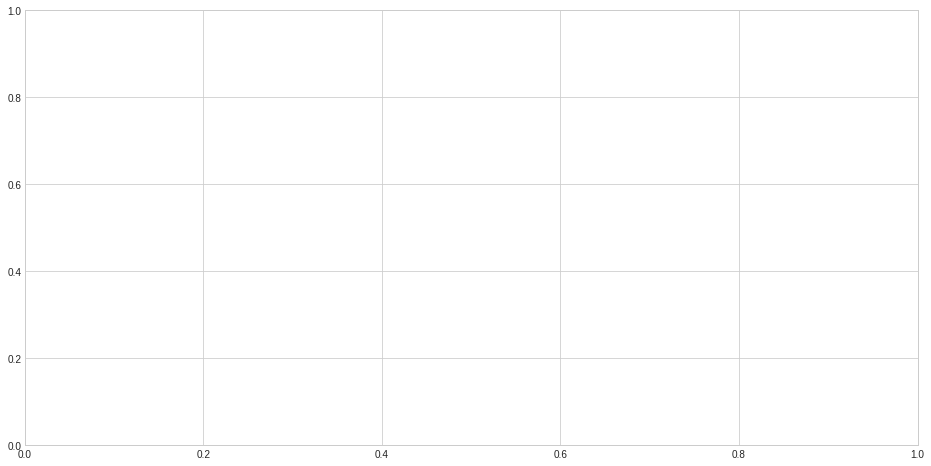

In [ ]:
barWidth=0.20
r1 = np.array(soldSF['SaleYear'])
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.bar(r1, soldOne['AV Diff']['mean'], width=barWidth, color=color1, label='Single family')
plt.bar(r2, soldTwo['AV Diff']['mean'], width=barWidth, color=color2, label='Two family')
plt.bar(r3, soldThr['AV Diff']['mean'], width=barWidth, color=color3, label='Three family')
plt.bar(r4, soldApt['AV Diff']['mean'], width=barWidth, color=color4, label='Apt')
plt.ylabel('Percent difference')
plt.title('Mean difference between sale price and assessed value at time of sale by year')
plt.legend()
plt.show()

# Largest differences between sale price and AV at time of sale

In [ ]:
sold[['ID', 'Code', 'Street', 'SaleYear', 'Sale Price', 'Sale AV', 'AV Diff']].sort_values(by=['AV Diff'], ascending=False).head(10).reset_index()

# Single-family Sale Price vs Assessed Value 

In [ ]:
single_family = sold[sold['Code'] == 210]
sold1 = single_family[['SaleYear', 'Sale Price', 'AV Diff']].groupby(['SaleYear']).agg(['count', 'mean']).reset_index()
sold1

# Two-family Sale Price vs Assessed Value 

In [ ]:
two_family = sold[sold['Code'] == 220]
sold2 = two_family[['SaleYear', 'Sale Price', 'AV Diff']].groupby(['SaleYear']).agg(['count', 'mean']).reset_index()
sold2

# Three-family Sale Price vs Assessed Value 

In [ ]:
three_family = sold[sold['Code'] == 230]
sold3 = three_family[['SaleYear', 'Sale Price', 'AV Diff']].groupby(['SaleYear']).agg(['count', 'mean']).reset_index()
sold3

# Apartments Sale Price vs Assessed Value 

In [ ]:
apartments = sold[sold['Code'] == 411]
sold4 = apartments[['SaleYear', 'Sale Price', 'AV Diff']].groupby(['SaleYear']).agg(['count', 'mean']).reset_index()
sold4

In [ ]:
#figure(num=None, figsize=(12,8), dpi=92, facecolor='w', edgecolor='k')
#plt.style.use('seaborn-whitegrid')

plt.plot(sold1['SaleYear'], sold1['AV Diff']['mean'], label='Single family')
plt.plot(sold2['SaleYear'], sold2['AV Diff']['mean'], label='Two family')
plt.plot(sold3['SaleYear'], sold3['AV Diff']['mean'], label='Three family')
plt.ylabel('Percent')
plt.title('Mean difference between sale price and assessed value at time of sale by year')
plt.legend(loc=2)
plt.show()

# Corridors with least increase in assessed value 2016-2020




In [ ]:
df_agg[df_agg['count'] > 20].sort_values(by=['avg'], ascending=True).head(10).reset_index()

# Increase in taxable properties per year

In [ ]:
totals = np.array([
    df[(df['2016 City'] > 1)].count()[0],
    df[(df['2017 City'] > 1)].count()[0],
    df[(df['2018 City'] > 1)].count()[0],
    df[(df['2019 City'] > 1)].count()[0],
    df[(df['2020 City'] > 1)].count()[0]
])

totalssf = np.array([
    df[(df['2016 City'] > 1) & (df.Code.eq(210))].count()[0],
    df[(df['2017 City'] > 1) & (df['Code'] == 210)].count()[0],
    df[(df['2018 City'] > 1) & (df['Code'] == 210)].count()[0],
    df[(df['2019 City'] > 1) & (df['Code'] == 210)].count()[0],
    df[(df['2020 City'] > 1) & (df['Code'] == 210)].count()[0]
])

totalsmf = np.array([
    df[(df['2016 City'] > 1) & (df.Code.isin([220,230,411]))].count()[0],
    df[(df['2017 City'] > 1) & (df.Code.isin([220,230,411]))].count()[0],
    df[(df['2018 City'] > 1) & (df.Code.isin([220,230,411]))].count()[0],
    df[(df['2019 City'] > 1) & (df.Code.isin([220,230,411]))].count()[0],
    df[(df['2020 City'] > 1) & (df.Code.isin([220,230,411]))].count()[0]
])

diffsf = np.array([
  totalssf[1] - totalssf[0],
  totalssf[2] - totalssf[1],    
  totalssf[3] - totalssf[2],    
  totalssf[4] - totalssf[3]                        
])

diffmf = np.array([
  totalsmf[1] - totalsmf[0],
  totalsmf[2] - totalsmf[1],    
  totalsmf[3] - totalsmf[2],    
  totalsmf[4] - totalsmf[3]                        
])

otherdiff = np.array([
  totals[1] - diffsf[0] -  diffmf[0] - totals[0],
  totals[2] - diffsf[1] -  diffmf[1] - totals[1],
  totals[3] - diffsf[2] -  diffmf[2] - totals[2],
  totals[4] - diffsf[3] -  diffmf[3] - totals[3],                        
])

#print("2016-17: %d, 2017-18: %d, 2018-19: %d, 2019-20: %d" % (b-a, c-b, d-c, e-d))

In [ ]:
newIn2017 = df[(df['2016 City'] < 1) & (df['2017 City'] > 1)]
newIn2018 = df[(df['2017 City'] < 1) & (df['2018 City'] > 1)]
newIn2019 = df[(df['2018 City'] < 1) & (df['2019 City'] > 1)]
newIn2020 = df[(df['2019 City'] < 1) & (df['2020 City'] > 1)]

newProperties = df[(df['2016 City'] < 1) & (df['2020 City'] > 1)]
sumNew = newProperties['2020 City'].sum()
sumNew

19049756

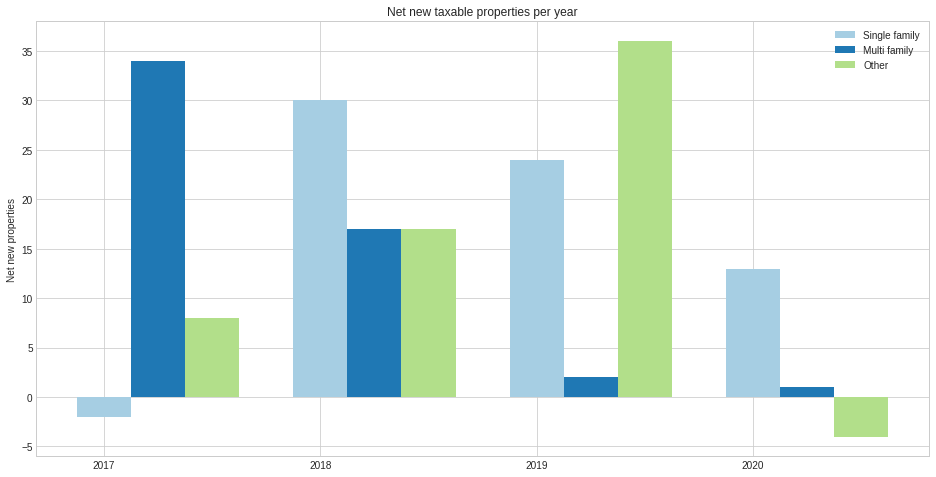

In [ ]:


from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

barWidth=0.25
r1 = np.array([2017,2018,2019,2020])
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]


plt.bar(r1, diffsf, color=color1, width=barWidth, label='Single family', align='center')
plt.bar(r2, diffmf, color=color2, width=barWidth, label='Multi family')
plt.bar(r3, otherdiff, color=color3, width=barWidth, label='Other')



plt.ylabel('Net new properties')
plt.title('Net new taxable properties per year')
plt.legend()
plt.show()

In [ ]:

#figure(num=None, figsize=(12, 8), dpi=92, facecolor='w', edgecolor='k')
#plt.style.use('seaborn-whitegrid')

plt.scatter(single_family['SaleDateTime'], single_family['AV Diff'], label='Single-family', s=single_family['Sale Price']/5000)
plt.scatter(two_family['SaleDateTime'], two_family['AV Diff'], label='Two-family', s=two_family['Sale Price']/5000)
plt.scatter(three_family['SaleDateTime'], three_family['AV Diff'],  label='Three-family', s=three_family['Sale Price']/5000)
plt.scatter(apartments['SaleDateTime'], apartments['AV Diff'],  label='Apartments', s=apartments['Sale Price']/5000)
plt.title('Sale price vs AV over time')
plt.legend(loc=2)
plt.show()

# Do homes or apartments (codes 210,220,230,411) with recent sales result in higher assessment increases?

In [ ]:
# Filter by all taxable properties, only apartments and residential
notsold = df[df['2020 City'] > 0].reset_index()
notsold = notsold[notsold['Sale Price'].isnull()]
notsold = notsold[notsold['Code'].isin([210,220,230,411])]

onlysold = sold[sold['Sale Price'].notnull()]
onlysold = onlysold[onlysold['SaleYear'] > 2014]
onlysold = onlysold[onlysold['Code'].isin([210,220,230,411])]

notsold_agg = notsold[['Code', 'Total Increase']].groupby('Code', as_index=False)['Total Increase'].agg({'avg':'mean', 'count':'count', 'std':'std'}).reset_index()
onlysold_agg = onlysold[['Code', 'Total Increase']].groupby('Code', as_index=False)['Total Increase'].agg({'avg':'mean', 'count':'count','std':'std'}).reset_index()
#figure(num=None, figsize=(12, 8), dpi=92, facecolor='w', edgecolor='k')

barWidth=0.25
r1 = np.array([1,2,3,4])
r2 = [x + barWidth for x in r1]

plt.subplot(1,1,1)
plt.bar(r1, notsold_agg['avg'],  label='No Recent Sale', width=barWidth, color=color1)
plt.bar(r2, onlysold_agg['avg'], label='Sale 2015-2020', width=barWidth, color=color2)
plt.ylabel('Percent Increase')
plt.title('No Recent Sale vs Recent Sale Assessment Increases 2016-2020')
plt.legend(loc=2)
plt.show()



KeyError: ignored

In [ ]:

fig = sns.boxplot(x="Code", y="Sale Price", data=onlysold[onlysold['SaleYear'] > 2014], hue="SaleYear")
fig.axis(ymin=0, ymax=500000);
fig.set_title('Sale price by code')
fig.set_xlabel('')
fig.set_xticklabels(['Single Family', 'Two Family', 'Three Family', 'Apts'])



In [ ]:

fig = sns.boxplot(x="Code", y="2020 City", data=ne[ne.Code.isin([210,220,230, 411])], hue="RecentSale")
fig.axis(ymin=0, ymax=600000);
fig.set_title('2020 assessed value by code')
fig.set_ylabel('Assessed value')
fig.set_xlabel('')
fig.set_xticklabels(['Single Family', 'Two Family', 'Three Family', 'Apts'])




In [ ]:

fig = sns.boxplot(x="Code", y="2020 City", data=sfAndMF, hue="2020Vacant")
fig.axis(ymin=0, ymax=600000);
fig.set_title('2020 assessed value (vacant registration)')
fig.set_ylabel('Assessed value')
fig.set_xlabel('')
fig.set_xticklabels(['Single Family', 'Two Family', 'Three Family', 'Apts'])



In [ ]:
fig = sns.boxplot(x="Code", y="2020Tax", data=sfAndMF, hue="Non-Homestead")
fig.axis(ymin=0, ymax=20000);
fig.set_title('2020 tax')
fig.set_ylabel('Tax')
fig.set_xlabel('')
fig.set_xticklabels(['Single Family', 'Two Family', 'Three Family', 'Apts'])


In [ ]:

fig = sns.boxplot(x="Code", y="2020 City", data=sfAndMF, hue="2020Violations")
fig.axis(ymin=0, ymax=600000);
fig.set_title('2020 assessed value (code violations)')
fig.set_ylabel('Assessed value')
fig.set_xlabel('')
fig.set_xticklabels(['Single Family', 'Two Family', 'Three Family', 'Apts'])



[Text(0, 0, 'Single Family'),
 Text(0, 0, 'Two Family'),
 Text(0, 0, 'Three Family'),
 Text(0, 0, 'Apts')]

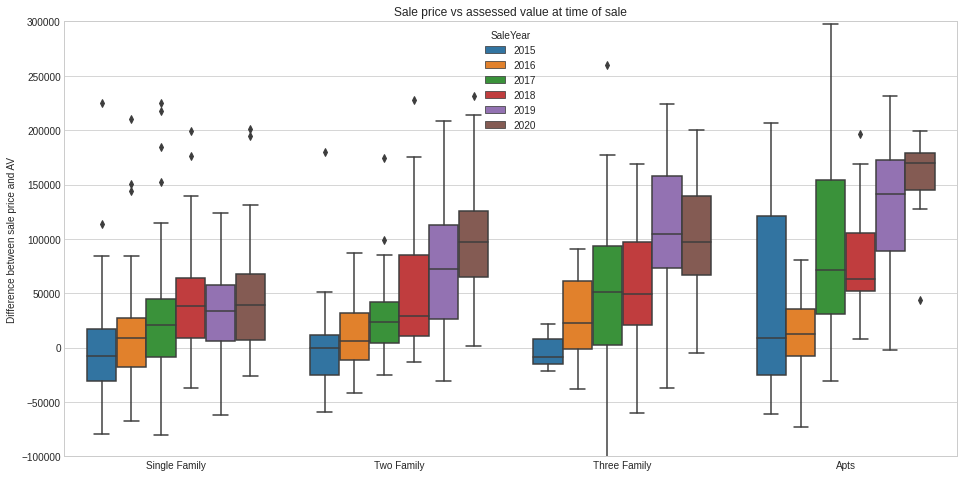

In [ ]:


notExemptAndSold = ne[(ne.Code.isin([210,220,230, 411])) & (ne.SaleYear > 2014)].sort_values(by=['SaleYear'])

fig = sns.boxplot(x="Code", y="SaleAssessDiff", data=notExemptAndSold, hue="SaleYear")
fig.axis(ymin=-100000, ymax=300000);
fig.set_title('Sale price vs assessed value at time of sale')
fig.set_ylabel('Difference between sale price and AV')
fig.set_xlabel('')
fig.set_xticklabels(['Single Family', 'Two Family', 'Three Family', 'Apts'])




Text(0.5, 0, '')

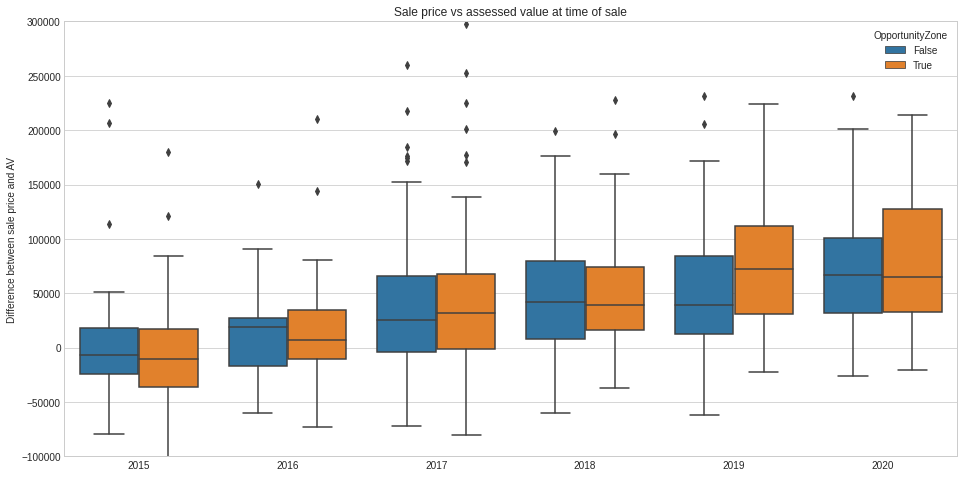

In [ ]:


notExemptAndSold = ne[(ne.Code.isin([210,220,230, 411])) & (ne.SaleYear >= 2015)].sort_values(by=['SaleYear'])

fig = sns.boxplot(x="SaleYear", y="SaleAssessDiff", data=notExemptAndSold, hue="OpportunityZone")
fig.axis(ymin=-100000, ymax=300000);
fig.set_title('Sale price vs assessed value at time of sale')
fig.set_ylabel('Difference between sale price and AV')
fig.set_xlabel('')
#fig.set_xticklabels(['Single Family', 'Two Family', 'Three Family', 'Apts'])




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


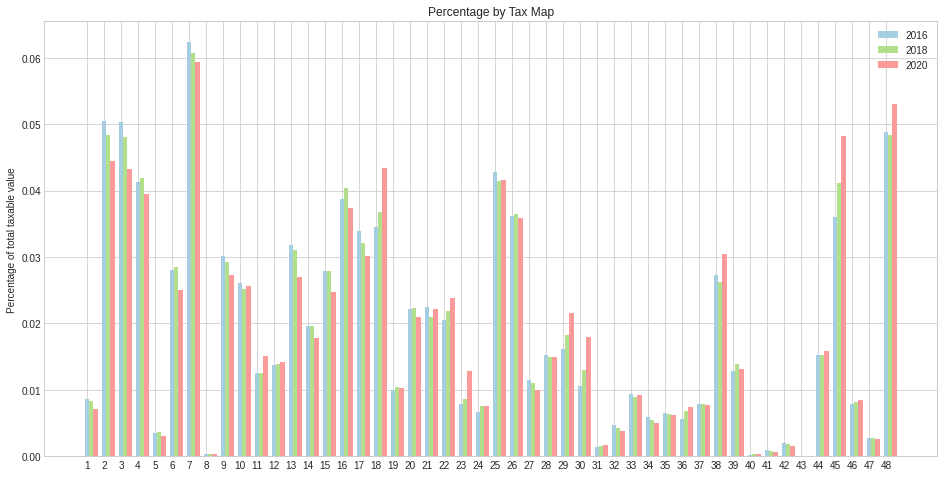

In [ ]:
nArray = range(49)
limitedNeighborhoods = sfAndMF[sfAndMF.NbhdCode.isin(nArray)]
neighborhoods = limitedNeighborhoods[['TaxMap', '2016 City', '2018 City', '2020 City']].groupby('TaxMap', as_index=False)['2016 City', '2018 City', '2020 City'].agg('sum')
nArray = neighborhoods.TaxMap.unique()

p2016 = neighborhoods['2016 City'] / sfAndMF['2016 City'].sum()
p2018 = neighborhoods['2018 City'] / sfAndMF['2018 City'].sum()
p2020 = neighborhoods['2020 City'] / sfAndMF['2020 City'].sum()

barWidth=0.25
r1 = np.array(nArray)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.bar(r1, p2016, color=color1, width=barWidth, label='2016')
plt.bar(r2, p2018, color=color3, width=barWidth, label='2018')
plt.bar(r3, p2020, color=color5, width=barWidth, label='2020')


plt.ylabel('Percentage of total taxable value')
plt.title('Percentage by Tax Map')
plt.legend()
plt.xticks(nArray)
plt.show()



In [ ]:
pDiff = p2020 - p2016

barWidth=0.25
r1 = np.array(nArray)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

plt.bar(r1, pDiff, color=color2, width=barWidth, label='2016-2020')

plt.ylabel('Increase/Decrease in percentage')
plt.title('Percentage by Tax Map')
plt.legend()
plt.xticks(nArray)
plt.show()

NameError: ignored

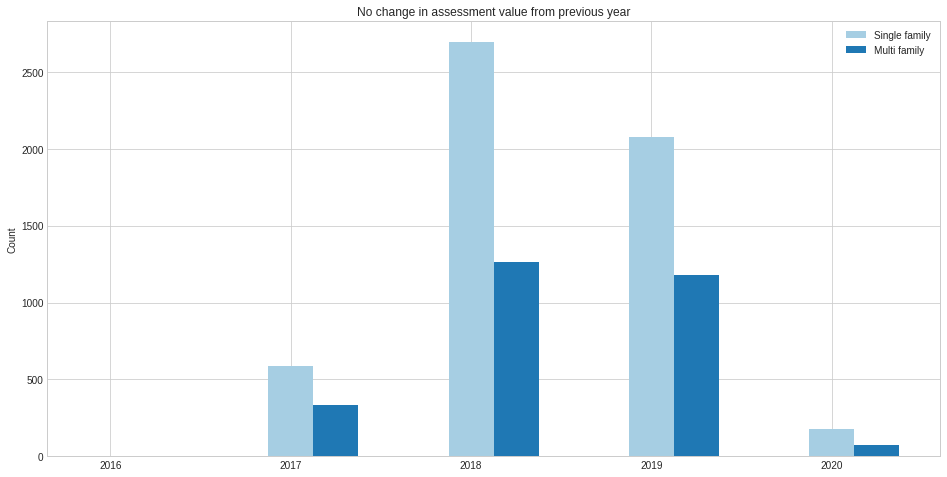

In [ ]:
sfNC = np.array([0,
    sf[(sf['2016 Full'] == sf['2017 Full'])].count()[0],
    sf[(sf['2017 Full'] == sf['2018 Full'])].count()[0],
    sf[(sf['2018 Full'] == sf['2019 Full'])].count()[0],
    sf[(sf['2019 Full'] == sf['2020 Full'])].count()[0]
])

mfNC = np.array([0,
    mf[(mf['2016 Full'] == mf['2017 Full'])].count()[0],
    mf[(mf['2017 Full'] == mf['2018 Full'])].count()[0],
    mf[(mf['2018 Full'] == mf['2019 Full'])].count()[0],
    mf[(mf['2019 Full'] == mf['2020 Full'])].count()[0]
])

barWidth=0.25
r1 = np.array([2016,2017,2018,2019,2020])
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]


plt.bar(r1, sfNC, color=color1, width=0.25, label='Single family')
plt.bar(r2, mfNC, color=color2, width=0.25, label='Multi family')
plt.ylabel('Count')
plt.title('No change in assessment value from previous year')
plt.legend()
plt.show()